# Credit Risk Analysis for Loan Approval

## Objective
Analyze loan applicant data to assess credit risk and build a model to predict loan approval.

## Dataset Overview
The dataset contains information about loan applicants including their demographics, credit history, loan amount, income, and loan approval status.

## Workflow
1. Load and explore the dataset
2. Preprocess the data
3. Perform EDA to understand key risk indicators
4. Build a classification model
5. Evaluate model performance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

In [2]:
df = pd.read_csv("loan_data.csv")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()

Shape: (1000, 6)

Columns: ['credit_score', 'loan_amount', 'income', 'employment_length', 'debt_to_income', 'loan_status']


,credit_score,loan_amount,income,employment_length,debt_to_income,loan_status
0,720,39012,54904,5,21.515381,1
1,779,12226,64834,8,38.682835,0
2,667,47927,32332,14,38.574933,1
3,380,23031,29296,13,10.766097,1
4,730,19984,93449,7,11.061158,1


## Data Preprocessing

In [3]:
# Basic stats and class balance
print(df.describe())
print("\nLoan status distribution:")
print(df["loan_status"].value_counts())
print(df["loan_status"].value_counts(normalize=True) * 100)

       credit_score   loan_amount         income  employment_length  \
count   1000.000000   1000.000000    1000.000000        1000.000000   
mean     578.011000  27864.049000   85898.098000           7.491000   
std      158.320195  12779.901056   37292.321425           4.072899   
min      300.000000   5039.000000   20066.000000           1.000000   
25%      447.000000  16736.750000   54873.750000           4.000000   
50%      575.500000  28427.000000   85413.000000           7.000000   
75%      722.000000  38790.750000  117725.750000          11.000000   
max      849.000000  49991.000000  149901.000000          14.000000   

       debt_to_income  loan_status  
count     1000.000000   1000.00000  
mean        25.293026      0.71500  
std          8.773379      0.45164  
min         10.013172      0.00000  
25%         17.840631      0.00000  
50%         25.319301      1.00000  
75%         33.000121      1.00000  
max         39.997162      1.00000  

Loan status distribution:


## Exploratory Data Analysis (EDA)

C:\Users\hp\AppData\Local\Temp\ipykernel_4464\4011665828.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="loan_status", data=df, palette="Set2")


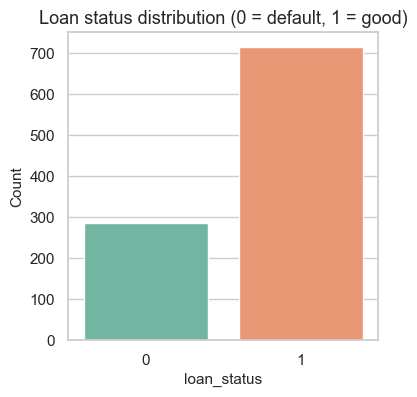

In [4]:
plt.figure(figsize=(4, 4))
sns.countplot(x="loan_status", data=df, palette="Set2")
plt.title("Loan status distribution (0 = default, 1 = good)")
plt.xlabel("loan_status")
plt.ylabel("Count")
plt.show()

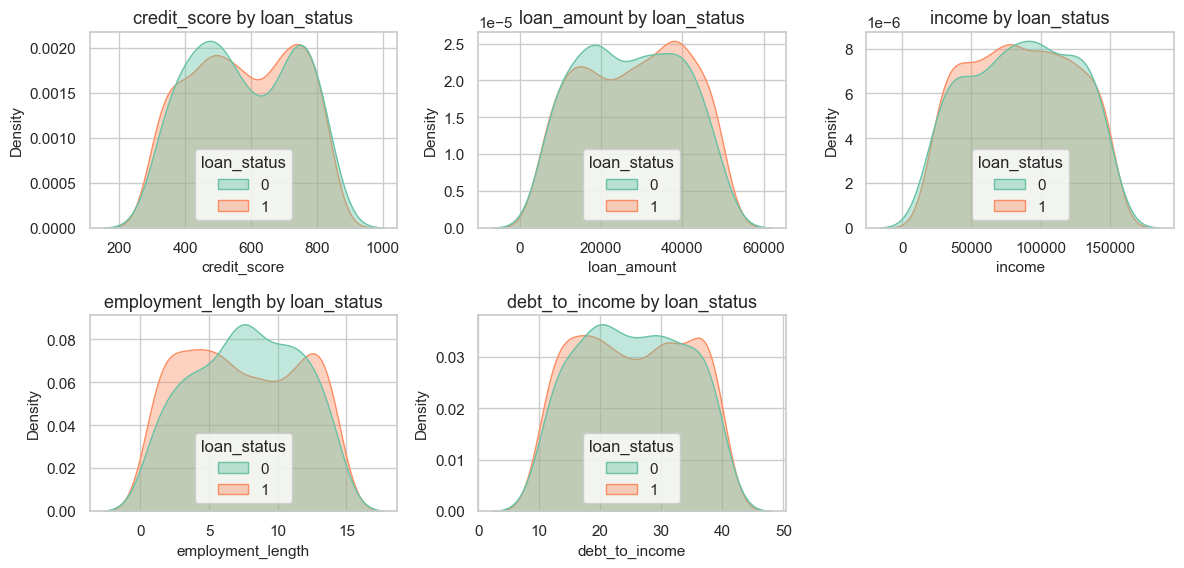

In [5]:
num_cols = ["credit_score", "loan_amount", "income",
            "employment_length", "debt_to_income"]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(
        data=df,
        x=col,
        hue="loan_status",
        common_norm=False,
        fill=True,
        alpha=0.4,
        ax=axes[i],
        palette="Set2"
    )
    axes[i].set_title(f"{col} by loan_status")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

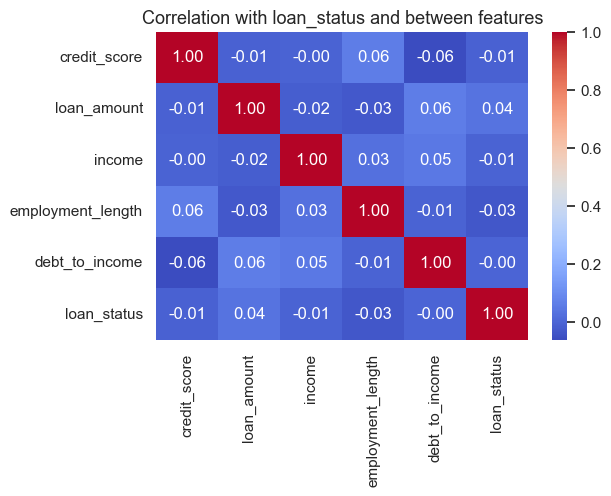

In [6]:
plt.figure(figsize=(6, 4))
corr = df[num_cols + ["loan_status"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation with loan_status and between features")
plt.show()

## Model Training and Evaluation

In [7]:
# Features and target
X = df[num_cols].copy()
y = df["loan_status"]

# Train–test split with stratification (preserve class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Train shape: (750, 5)  Test shape: (250, 5)


In [8]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic regression with class weights

In [9]:
# Handle imbalance via class_weight='balanced'
log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

In [10]:
# Metrics
print("Classification report (default threshold 0.5):")
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print("Confusion matrix [tn, fp; fn, tp]:")
print(cm)

roc = roc_auc_score(y_test, y_proba)
print(f"\nROC-AUC: {roc:.3f}")

Classification report (default threshold 0.5):
              precision    recall  f1-score   support

           0      0.280     0.465     0.349        71
           1      0.712     0.525     0.605       179

    accuracy                          0.508       250
   macro avg      0.496     0.495     0.477       250
weighted avg      0.589     0.508     0.532       250

Confusion matrix [tn, fp; fn, tp]:
[[33 38]
 [85 94]]

ROC-AUC: 0.496


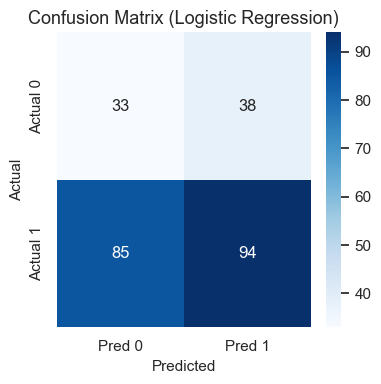

In [11]:
plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["Actual 0", "Actual 1"]
)
plt.title("Confusion Matrix (Logistic Regression)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

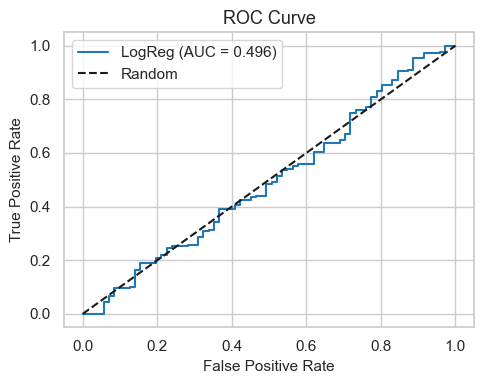

In [12]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"LogReg (AUC = {roc:.3f})", color="tab:blue")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

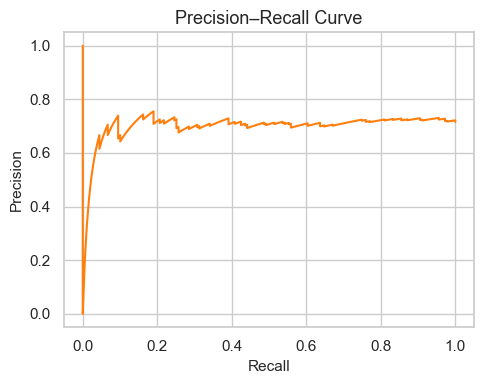

In [13]:
# Precision–Recall curve
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(5, 4))
plt.plot(rec, prec, color="tab:orange")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.show()

In [14]:
def threshold_table(y_true, y_scores, thresholds):
    rows = []
    for thr in thresholds:
        y_hat = (y_scores >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        rows.append({
            "threshold": thr,
            "tn": tn, "fp": fp, "fn": fn, "tp": tp,
            "recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
            "precision": tp / (tp + fp) if (tp + fp) > 0 else 0
        })
    return pd.DataFrame(rows)

thr_df = threshold_table(y_test, y_proba, thresholds=np.linspace(0.2, 0.8, 7))
thr_df

,threshold,tn,fp,fn,tp,recall,precision
0,0.2,0,71,0,179,1.00000,0.716000
1,0.3,0,71,0,179,1.00000,0.716000
2,0.4,0,71,0,179,1.00000,0.716000
3,0.5,33,38,85,94,0.52514,0.712121
4,0.6,71,0,179,0,0.00000,0.000000
5,0.7,71,0,179,0,0.00000,0.000000
6,0.8,71,0,179,0,0.00000,0.000000


## Conclusion
- The logistic regression model predicts loan approval based on applicant data.
- Accuracy and classification metrics provide insights into model performance.
- Further enhancements could include testing other models and hyperparameter tuning.